## Introduction

- Name: Surya Karunia Ramadhan
- Dashboard: https://public.tableau.com/app/profile/surya.ramadhan/viz/Tableu_milestone/ConvertionAnalysisofDigitalMarketingData?publish=yes

**Problem Identification:**
Topic: Effectiveness of Digital Marketing Campaigns in Increasing Conversions Based on Customer Demographic Segments.

**Background:**
XYZ Co. is an e-commerce company planning to launch an advertising campaign to promote its products. However, several previous campaigns have fallen short of the expected customer conversion numbers. As a data scientist for XYZ Co., I have been tasked with identifying which variables most influence conversion rates. Data from previous campaigns will be used for this evaluation.

**Problem Statement:**
Company XYZ has experienced challenges in achieving the desired customer conversion rates from previous digital marketing campaigns. To improve future campaign effectiveness, it is crucial to identify the factors that most significantly influence conversions. By analyzing data from past campaigns, this study aims to uncover the variables that have the highest correlation to conversion rates. The insights gained will help optimize marketing strategies and increase new customer acquisition. A comprehensive statistical analysis will be conducted over a three-month period to determine the strongest relationships between these variables and conversions.

**Problem Identification:**
Identify which variables in the dataset influence conversions.
Determine which statistical methods will be used to assess the relationship between the variables and conversion rates.

## Import Libraries

In [1]:
from google.oauth2 import service_account
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

c:\Users\surya\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data Loading

In [2]:
SERVICE_ACCOUNT_FILE_PATH = r"hactiv8-435209-c111d2a90bc0.json"

SCOPES = ['https://www.googleapis.com/auth/bigquery']

credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE_PATH, scopes=SCOPES)

client = bigquery.Client(credentials=credentials)

In [3]:
query = """
SELECT CustomerID,
    CASE
        WHEN Age < 20 THEN 'Young'
        WHEN Age >= 20 AND Age < 40 THEN 'Young Adults'
        WHEN Age >= 40 AND Age < 60 THEN 'Middle-aged Adults'
        ELSE 'Old'
    END AS AgeGroup,
    Gender,
    CASE
        WHEN Income < 50000 THEN 'Low'
        WHEN Income >= 50000 AND Income < 100000 THEN 'Average'
        ELSE 'High'
    END AS IncomeLevel,
    CampaignChannel,
    CampaignType,
    AdSpend,
    ClickThroughRate,
    ConversionRate,
    WebsiteVisits,
    PagesPerVisit,
    TimeOnSite,
    SocialShares,
    EmailOpens,
    EmailClicks,
    PreviousPurchases,
    LoyaltyPoints,
    Conversion
FROM `hactiv8-435209.milestone_project.digital_marketing_campaign_dataset`
"""
df = client.query(query).to_dataframe()
df.head()

,CustomerID,AgeGroup,Gender,IncomeLevel,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,8559,Middle-aged Adults,Female,High,Email,Awareness,7484.584349,0.174822,0.031952,14,8.617106,14.620567,0,12,8,0,4651,1
1,9278,Old,Male,High,SEO,Conversion,3885.177190,0.132613,0.114481,21,9.025713,5.975304,0,8,3,0,1990,1
2,9473,Middle-aged Adults,Female,Average,PPC,Retention,1741.259484,0.057290,0.096675,34,1.037859,2.763133,0,4,5,0,4486,0
3,9487,Young Adults,Female,Average,Email,Retention,9164.675433,0.102293,0.072027,23,6.473141,5.948022,0,18,9,0,1006,1
4,11885,Old,Female,High,SEO,Conversion,1788.111950,0.065308,0.062966,37,7.304789,11.756902,0,16,1,0,95,1


In [4]:
val_count = df['Conversion'].value_counts()
print(val_count)

Conversion
1    7012
0     988
Name: count, dtype: Int64


To aid in data interpretation, the data owner has prepared a data dictionary:

| **Column Name**        | **Description**                                                                |
|------------------------|--------------------------------------------------------------------------------|
| **CustomerID**          | A unique identifier for each customer.                                         |
| **AgeGroup**            | The age group of the customer.                                                 |
| **Gender**              | The gender of the customer (Male/Female).                                      |
| **IncomeGroup**         | The income group of the customer.                                              |
| **CampaignChannel**     | The channel through which the marketing campaign was delivered (Email, Social Media, SEO, PPC, Referral). |
| **CampaignType**        | The type of marketing campaign (Awareness, Consideration, Conversion, Retention). |
| **AdSpend**             | The amount spent on the marketing campaign in USD.                             |
| **ClickThroughRate**    | The rate at which customers click on the marketing content.                    |
| **ConversionRate**      | The rate at which clicks convert into the desired actions (e.g., purchases).   |
| **AdvertisingPlatform** | Confidential.                                                                  |
| **AdvertisingTool**     | Confidential.                                                                  |
| **WebsiteVisits**       | The number of visits to the website.                                           |
| **PagesPerVisit**       | The average number of pages visited per session.                               |
| **TimeOnSite**          | The average time spent on the website per visit (in minutes).                  |
| **SocialShares**        | The number of times the marketing content was shared on social media.          |
| **EmailOpens**          | The number of times marketing emails were opened.                              |
| **EmailClicks**         | The number of times links in marketing emails were clicked.                    |
| **PreviousPurchases**   | The number of previous purchases made by the customer.                         |
| **LoyaltyPoints**       | The number of loyalty points accumulated by the customer.                      |
| **Conversion**          | A binary variable indicating whether the customer converted (1) or not (0).    |



### Data Cleaning

In [5]:
print(df.info())
print(df[df.duplicated()])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         8000 non-null   Int64  
 1   AgeGroup           8000 non-null   object 
 2   Gender             8000 non-null   object 
 3   IncomeLevel        8000 non-null   object 
 4   CampaignChannel    8000 non-null   object 
 5   CampaignType       8000 non-null   object 
 6   AdSpend            8000 non-null   float64
 7   ClickThroughRate   8000 non-null   float64
 8   ConversionRate     8000 non-null   float64
 9   WebsiteVisits      8000 non-null   Int64  
 10  PagesPerVisit      8000 non-null   float64
 11  TimeOnSite         8000 non-null   float64
 12  SocialShares       8000 non-null   Int64  
 13  EmailOpens         8000 non-null   Int64  
 14  EmailClicks        8000 non-null   Int64  
 15  PreviousPurchases  8000 non-null   Int64  
 16  LoyaltyPoints      8000 

Based on the data information, there are no missing values in the dataset. All data types are also correct, so no further cleaning is required.

## Exploratory Data Analysis

To determine the correlation between the features in the dataset and the target variable, two statistical analyses will be employed: correlation analysis and hypothesis testing. 

**Correlation Analysis:**
This analysis measures the strength and direction of the relationship between numerical features and the target variable. Common methods include Pearson's correlation coefficient for linear relationships and Spearman's rank correlation for non-linear relationships.

**Hypothesis Testing:**
This analysis assesses whether there is enough evidence to support a specific hypothesis regarding the relationships between features and the target variable. Techniques such as t-tests, chi-square tests, or ANOVA can be used depending on the nature of the data and the research question.

In [6]:
num_col_df = df[[
    'CustomerID', 
    'WebsiteVisits', 
    'SocialShares', 
    'EmailOpens', 
    'EmailClicks', 
    'PreviousPurchases', 
    'LoyaltyPoints', 
    'AdSpend', 
    'ClickThroughRate', 
    'ConversionRate', 
    'PagesPerVisit', 
    'TimeOnSite',
    'Conversion'
]]

num_col_df.head()

,CustomerID,WebsiteVisits,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdSpend,ClickThroughRate,ConversionRate,PagesPerVisit,TimeOnSite,Conversion
0,8559,14,0,12,8,0,4651,7484.584349,0.174822,0.031952,8.617106,14.620567,1
1,9278,21,0,8,3,0,1990,3885.177190,0.132613,0.114481,9.025713,5.975304,1
2,9473,34,0,4,5,0,4486,1741.259484,0.057290,0.096675,1.037859,2.763133,0
3,9487,23,0,18,9,0,1006,9164.675433,0.102293,0.072027,6.473141,5.948022,1
4,11885,37,0,16,1,0,95,1788.111950,0.065308,0.062966,7.304789,11.756902,1


### Correlation Analysis

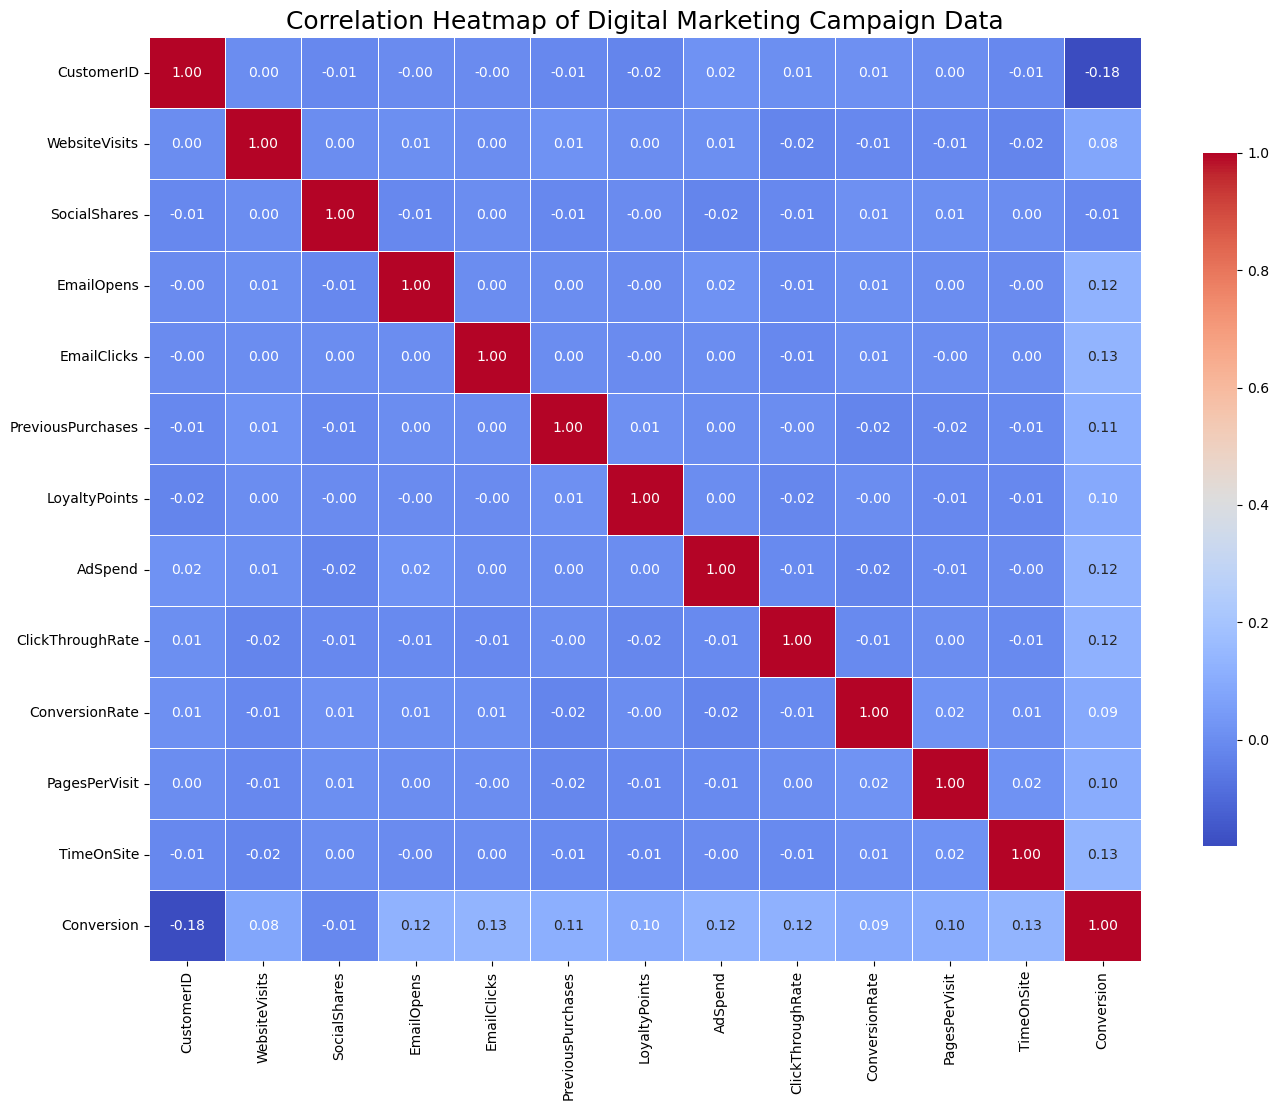

In [7]:
correlation_matrix = num_col_df.corr()

plt.figure(figsize=(16, 12))

sns.heatmap(
    correlation_matrix, 
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar_kws={"shrink": 0.75}
)

plt.title('Correlation Heatmap of Digital Marketing Campaign Data', fontsize=18)
plt.show()

The scores obtained from the correlation analysis through the heatmap reveal weak correlations for all features, with the highest correlation score obtained being only 0.13 for **TimeOnSite** and **EmailClicks**.

The initial speculation for these weak correlation values is due to the imbalance of the data.

The correlation analysis above is primarily conducted to assess the linear correlation between the features and the target variable. To explore non-linear correlations, a hypothesis analysis will be used.

### Hypothesis Analysis

#### Chi-Square Test on the Relationship Between CampaignType and Conversion

α = 5% or 0.05

H0: There is no relationship between CampaignType and Conversion.

H1: There is a relationship between CampaignType and Conversion.


In [8]:
contingency_table = pd.crosstab(df['CampaignType'], df['Conversion'])
res = stats.chi2_contingency(contingency_table)
print("P-value:", res.pvalue)

P-value: 3.3983347098681334e-18


With a p-value obtained from the Chi-Square test of 3.4e-18, which is below α (0.05), the null hypothesis is rejected. This indicates that there is a relationship between CampaignType and Conversion.

#### Chi-Square Test on the Relationship Between CampaignChannel and Conversion

α = 5% or 0.05

H0: There is no relationship between CampaignChannel and Conversion.

H1: There is a relationship between CampaignChannel and Conversion.


In [9]:
contingency_table = pd.crosstab(df['CampaignChannel'],df['Conversion'])
res = stats.chi2_contingency(contingency_table)
print("P-value:",res.pvalue)

P-value: 0.5944499903760994


With a p-value obtained from the Chi-Square test of 0.59, which is above α (0.05), the null hypothesis is accepted. This means that for Campaign Channel and Conversion, there is no relationship between the two variables.

#### Chi-Square Test on the Relationship Between Gender and Conversion

α = 5% or 0.05

H0: There is no relationship between Gender and Conversion.

H1: There is a relationship between Gender and Conversion.


In [10]:
contingency_table_gender = pd.crosstab(df['Gender'], df['Conversion'])
res_gender = stats.chi2_contingency(contingency_table_gender)
print("P-value:", res_gender.pvalue)

P-value: 0.9510312300044484


With a p-value obtained from the Chi-Square test of 0.95, which is above α (0.05), the null hypothesis is accepted. This means that for Gender and Conversion, there is no relationship between the two variables.

#### Chi-Square Test on the Relationship Between Age Group and Conversion

α = 5% or 0.05

H0: There is no relationship between Age Group and Conversion.

H1: There is a relationship between Age Group and Conversion.


In [11]:
contingency_table_age = pd.crosstab(df['AgeGroup'], df['Conversion'])
res_age = stats.chi2_contingency(contingency_table_gender)
print("P-value:", res_gender.pvalue)

P-value: 0.9510312300044484


With a p-value obtained from the Chi-Square test of 0.95, which is above α (0.05), the null hypothesis is accepted. This means that for Age Group and Conversion, there is no relationship between the two variables.

#### Chi-Square Test on the Relationship Between Income evel and Conversion

α = 5% or 0.05

H0: There is no relationship between Age Income Level and Conversion.

H1: There is a relationship between Age Income Level and Conversion.

In [12]:
contingency_table_income = pd.crosstab(df['IncomeLevel'], df['Conversion'])
res_gender = stats.chi2_contingency(contingency_table_income)
print("P-value:", res_gender.pvalue)

P-value: 0.6446479318294127


With a p-value obtained from the Chi-Square test of 0.64, which is above α (0.05), the null hypothesis is accepted. This means that for Income Level and Conversion, there is no relationship between the two variables.

From the hypothesis analysis, only Campaign Type has a significant correlation with the target variable. To assist the marketing team in developing a better strategy for the upcoming campaign, it is beneficial for them to know which campaign type yields the highest conversions.

We will compare each campaign type with the highest correlation value obtained from the heatmap correlation analysis, along with an additional variable that we believe is important to consider when creating a campaign strategy: AdSpend, or the total cost spent on the campaign.

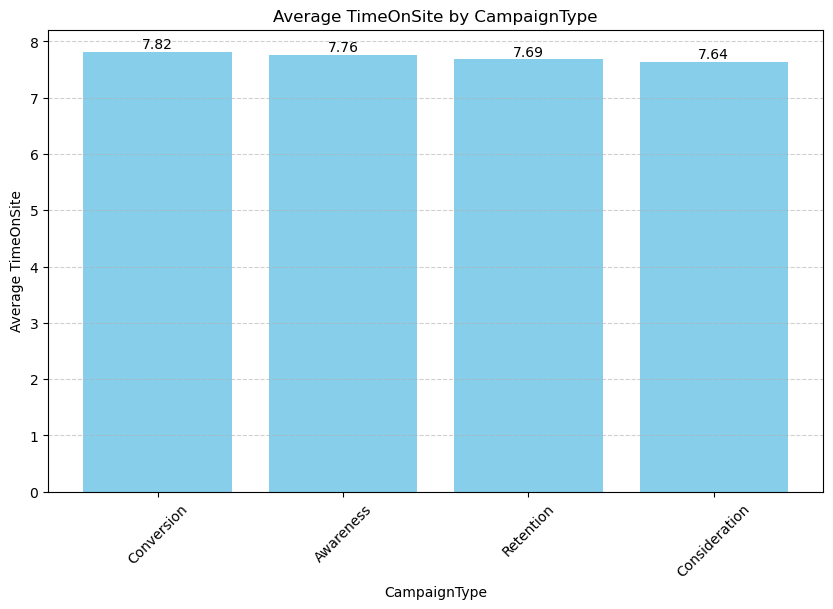

In [13]:
def plot_bar_chart(data, x, y, sort_order='descending'):
    """
    Plots the average y value by the x value as a bar chart.

    Parameters:
        data (DataFrame): The input DataFrame containing the data.
        x (str): The name of the column to be used as the x-axis.
        y (str): The name of the column to be used as the y-axis.
        sort_order (str): 'ascending' to sort from lowest to highest, 'descending' for highest to lowest.
    """
    average_values = data.groupby(x)[y].mean().reset_index()

    if sort_order == 'ascending':
        average_values = average_values.sort_values(by=y, ascending=True)
    else:
        average_values = average_values.sort_values(by=y, ascending=False)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(average_values[x], average_values[y], color='skyblue')
    plt.xlabel(x)
    plt.ylabel(f'Average {y}')
    plt.title(f'Average {y} by {x}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

    plt.show()

plot_bar_chart(df, 'CampaignType', 'TimeOnSite', sort_order='descending')

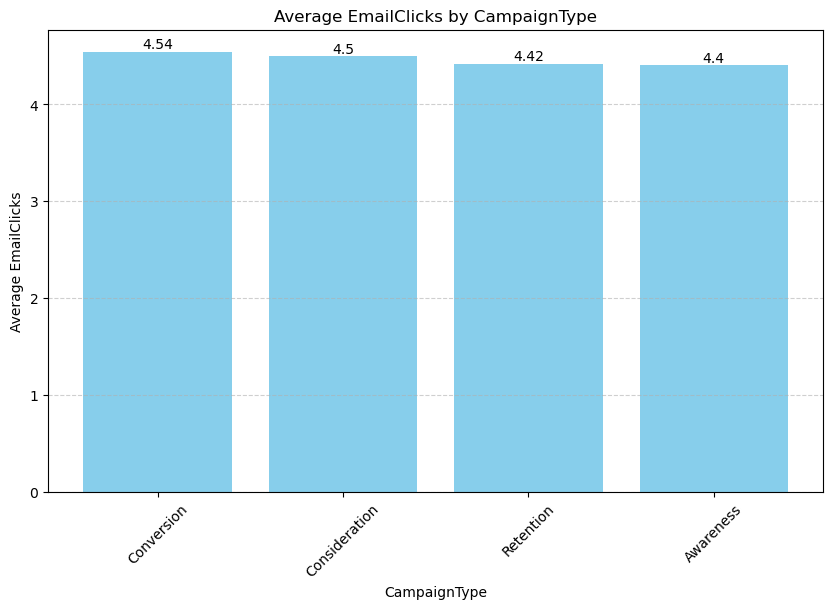

In [14]:
plot_bar_chart(df, 'CampaignType', 'EmailClicks', sort_order='descending')

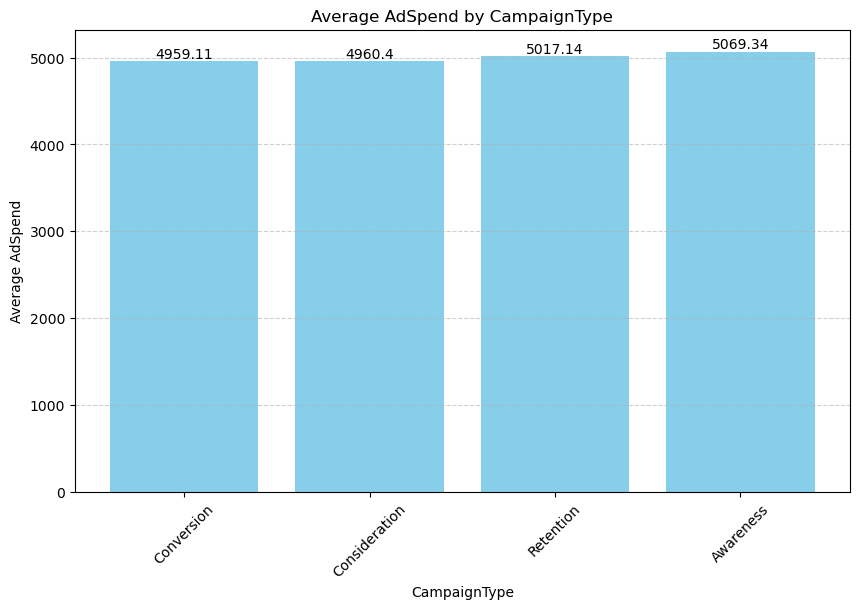

In [15]:
plot_bar_chart(df, 'CampaignType', 'AdSpend', sort_order='ascending')

## Conclusion

- CampaignType shows a significant relationship with conversion, as evidenced by the chi-square test, even though the heatmap revealed weak linear correlations.
- Weak positive correlations were found for TimeOnSite, EmailClicks, and indicating they have some influence on conversion.
- Analysis of the average values for TimeOnSite, EmailClicks, and AdSpend indicates that of the four campaign types (Awareness, Consideration, Conversion, Retention), the Conversion type is the most effective for driving customer purchases.

### Recomendation

- Prioritize Conversion Campaigns.
- Enhance Website Experience to increase customer engagement and extend browsing time, resulting in a higher TimeOnSite.
- nhance Email Marketing to boost customer motivation to open ads and increase EmailClicks.